# YT 2020: MSTAT Production

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [1]:
import sys, os, re, logging
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pformat

%matplotlib inline

cwd = os.getcwd()
preorder_key = max(re.findall(r"(preorder/v\d+feb)", cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path),
                 str(capacity_path / preorder_key),
                 str(capacity_path / ("../" * 4))])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.lib.tools import today
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020feb.input_data.forecast_options import forecast_end_date
from market.sre.tools.capacity.preorder.v2020feb.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020feb.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020feb.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020feb.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020feb.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020feb.additional.YT.tools import clean_YT_account

## Настройки

In [5]:
# откуда смотреть историю потребления
date_start = today(minus_days=365, astype=str)
date_end = today(minus_days=1, astype=str)

# учитывать ли пики в пуле?
consider_peaks = False

# verbose
verbose = True

# grid
grid=True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 2
features = [Feature.DAU, Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.MSTAT

In [6]:
notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/YT/calculations/mstat_testing.ipynb"
notebook_filename

'https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/preorder/v2020feb/additional/YT/calculations/mstat_testing.ipynb'

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### Env

In [10]:
env = 'production'

## Disk

#### Accounts

In [11]:
labels = 'mst', 'analyst'

_hahn_accounts = [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in hahn_accounts if (labels[0] in account or labels[1] in account) and env in account] + ['logfeller-market']]
_arnold_accounts = [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and env in account] + ['logfeller-market']]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if (labels[0] in account or labels[1] in account) not in [account for account in seneca_sas_accounts if (labels[0] in account or labels[1] in account) and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in seneca_man_accounts if (labels[0] in account or labels[1] in account) and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in seneca_vla_accounts if (labels[0] in account or labels[1] in account) and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-analyst', 'market-mst-development', 'market-mst-prestable', 'market-mst-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-analyst', 'market-mst-development', 'market-mst-prestable', 'market-mst-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: ['market-crm-production', 'market-indexer-production', 'market-indexer-testing', 'pricelabs', 'yamarec-production'], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: []}


##### Disk usage history and forecast, GB

HAHN DEFAULT usage: 40183 / 373760 Gb = 10.75 %


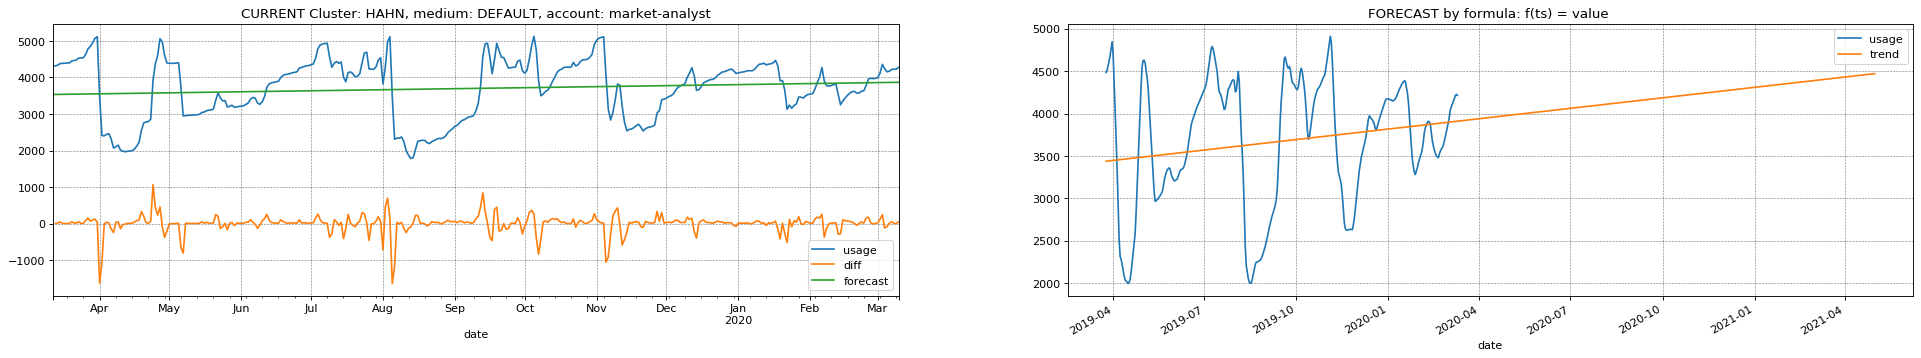

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.08356938066531189,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.0455121359750387}


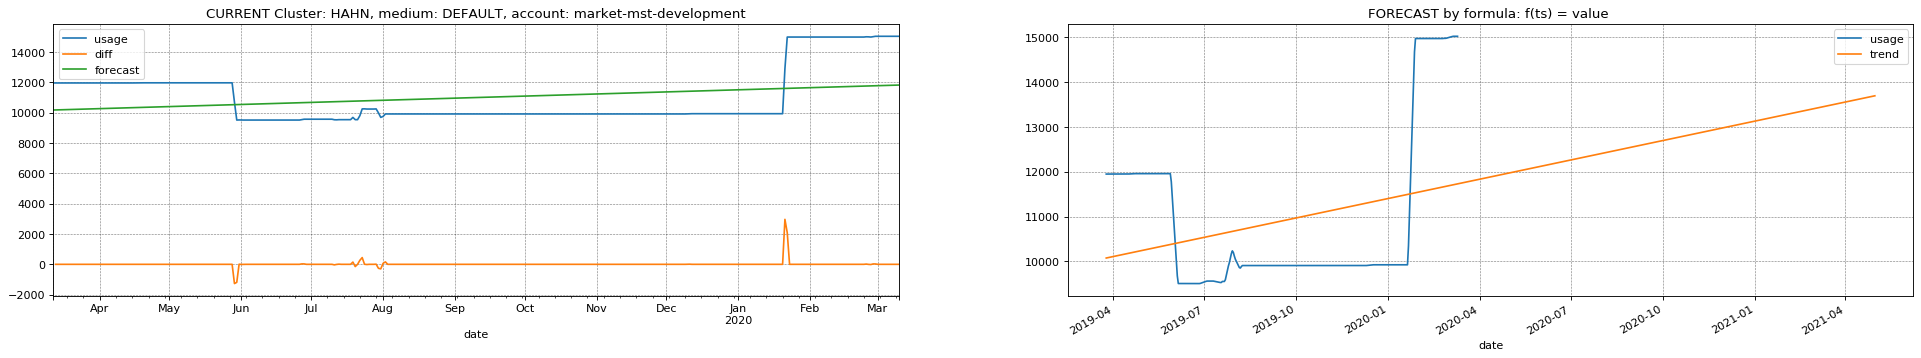

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.2313899754647613,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.06560334142568287}


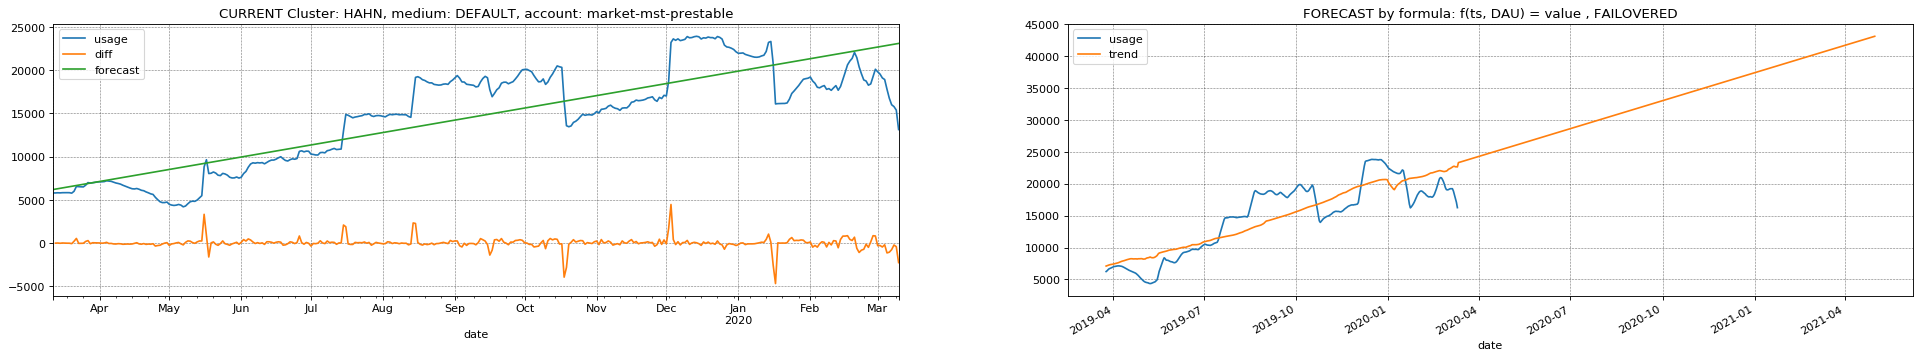

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.7232007254973829}


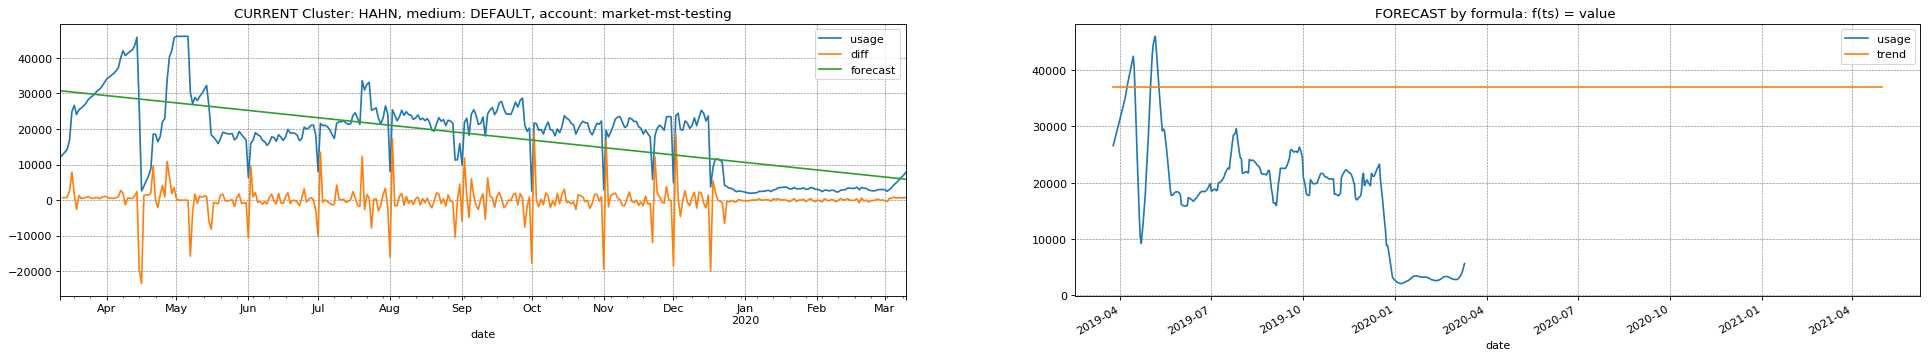

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.06227112181950725,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.4322067586082011}


HAHN SSD usage: None / None Gb = 0 %


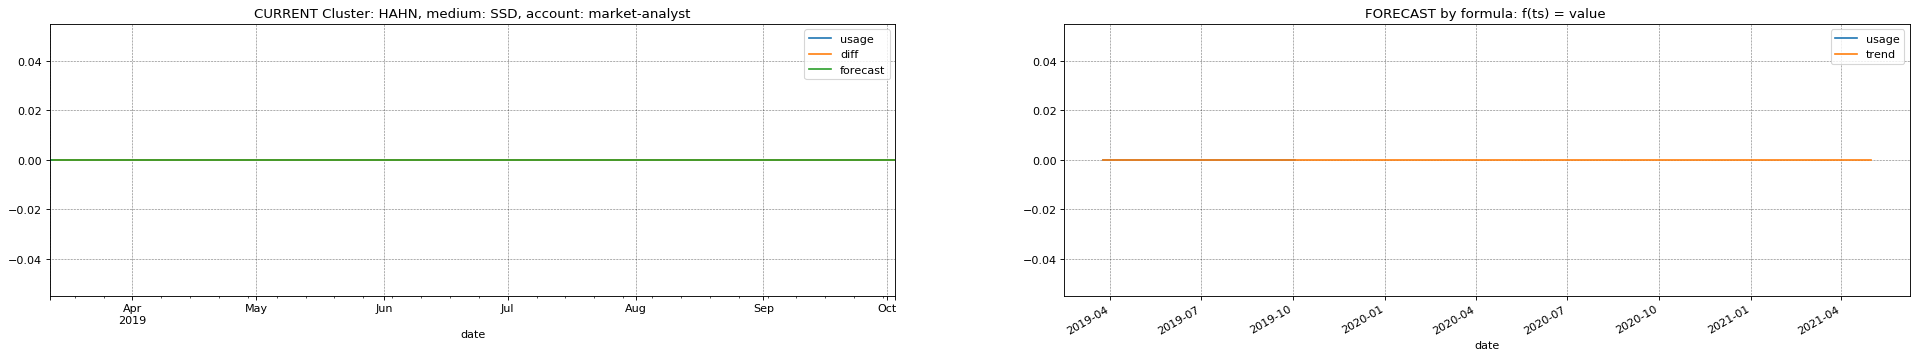

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


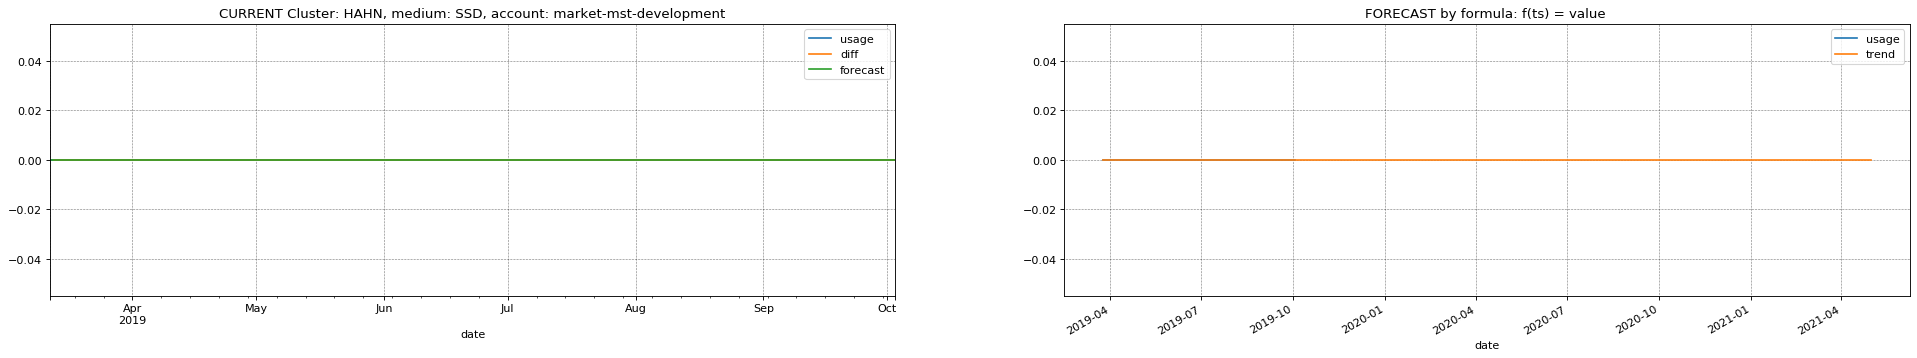

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


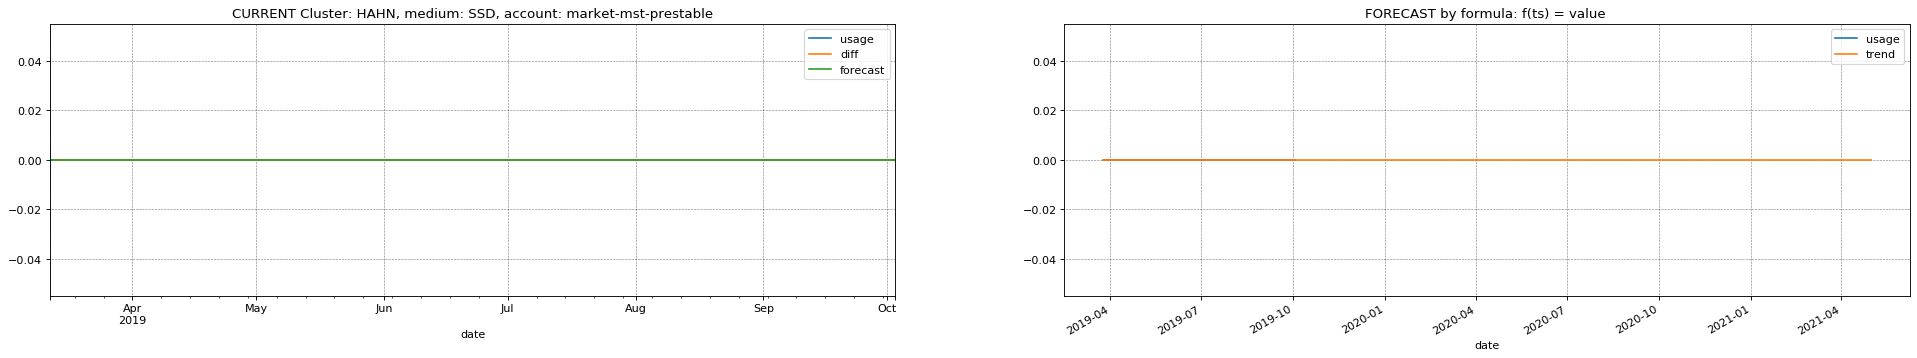

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


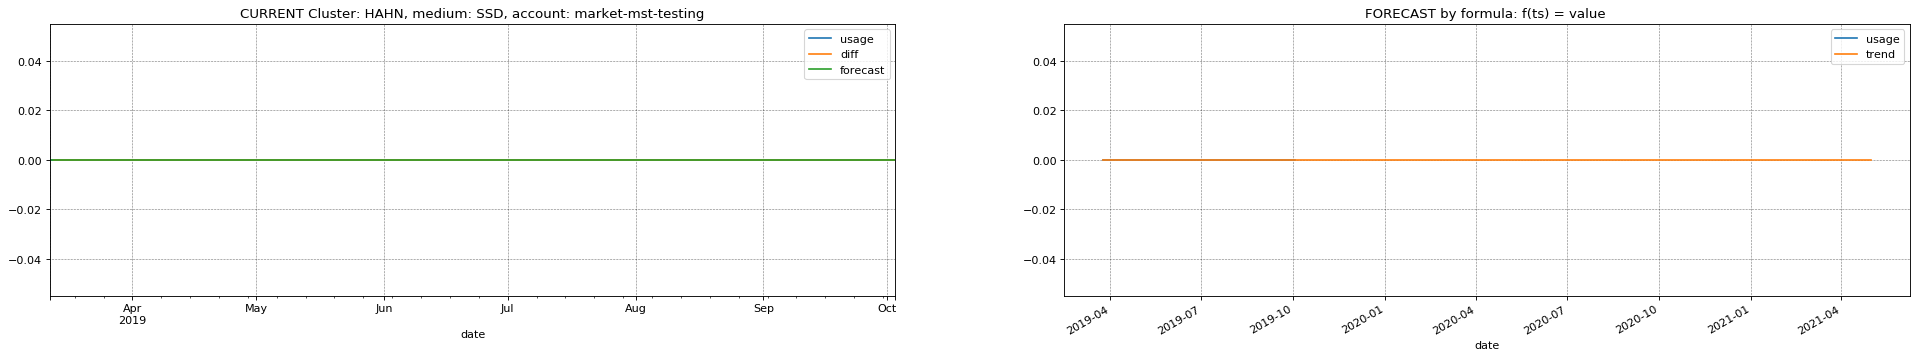

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


ARNOLD DEFAULT usage: 4066 / 373760 Gb = 1.09 %


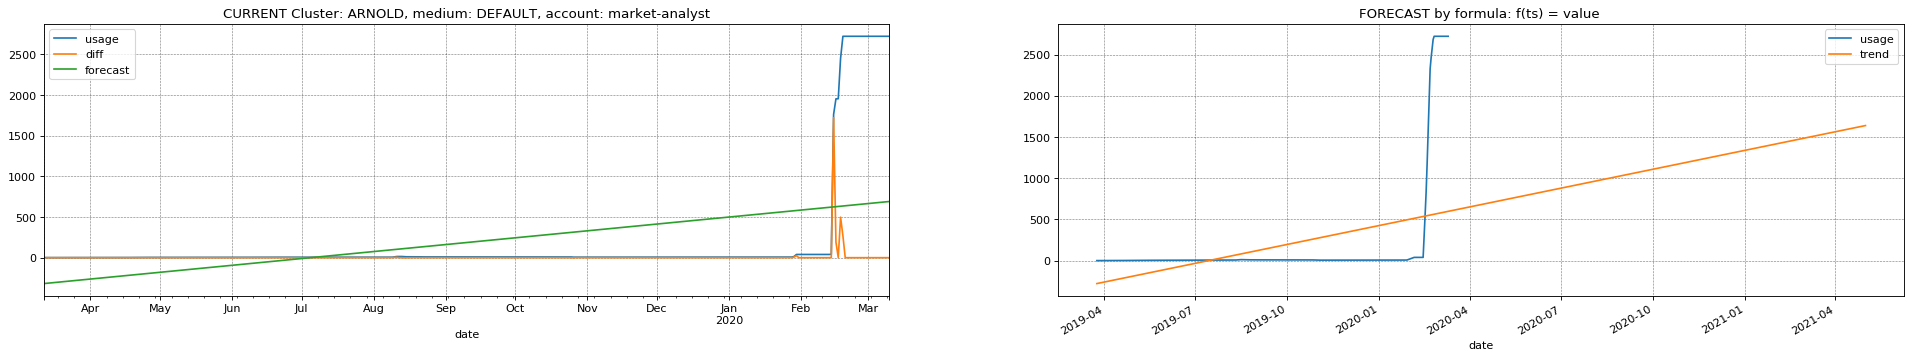

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.382089024435015,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.15249530931711638}


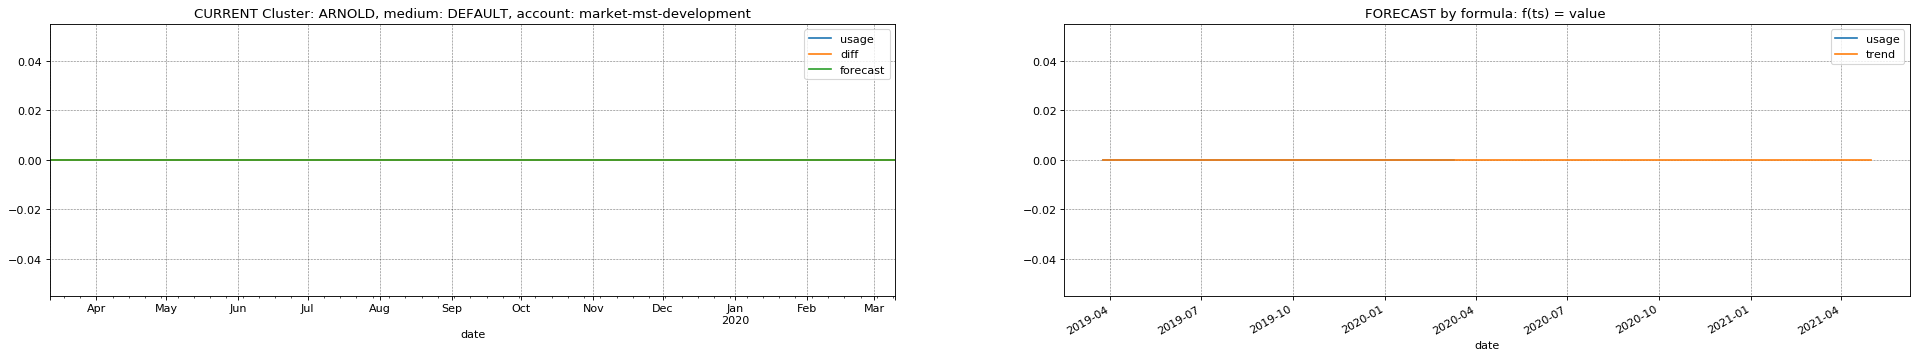

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


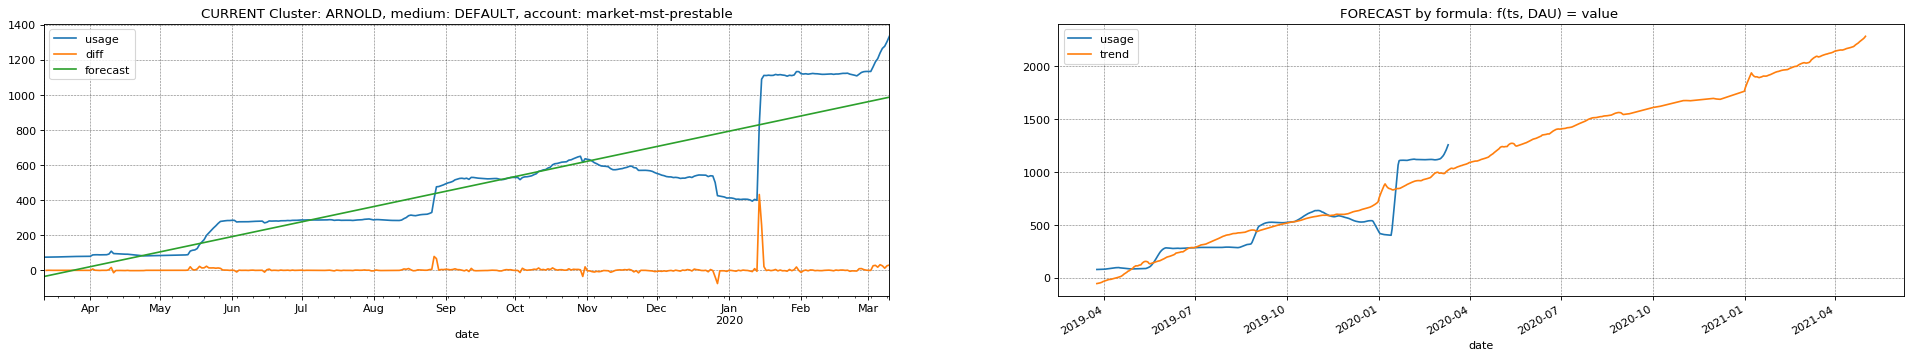

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.6139819659495815}


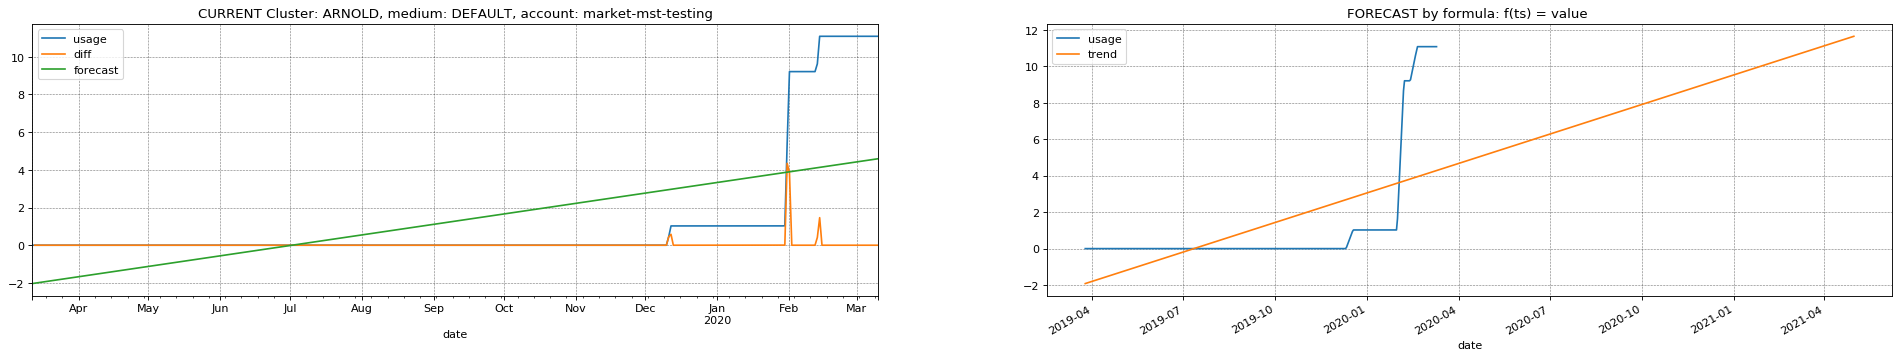

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.33374923464460793,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.2545124887849622}


ARNOLD SSD usage: None / None Gb = 0 %


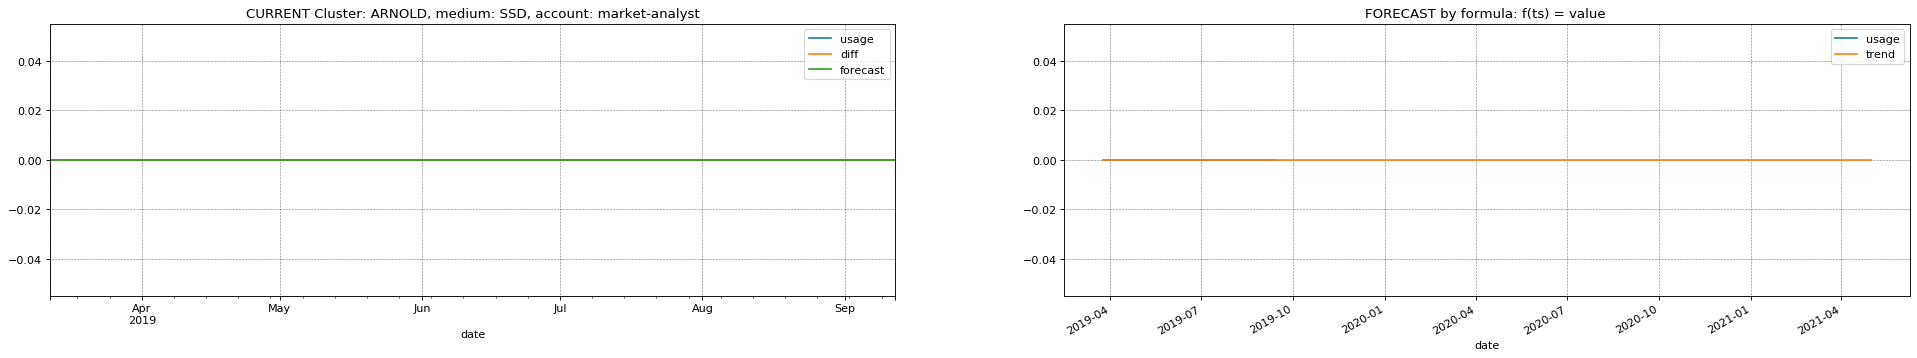

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


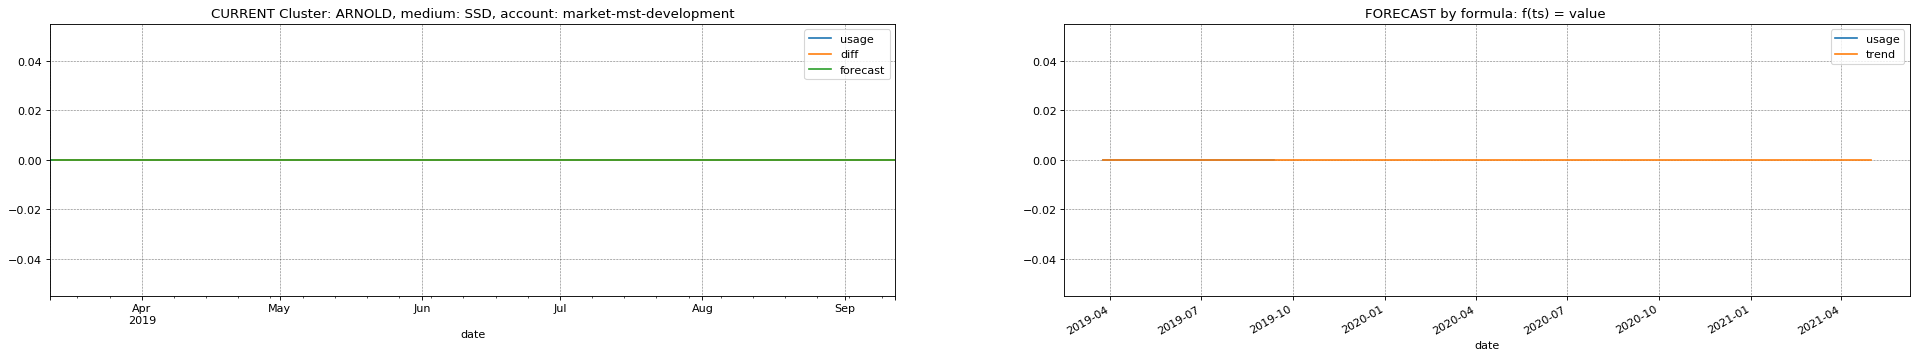

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


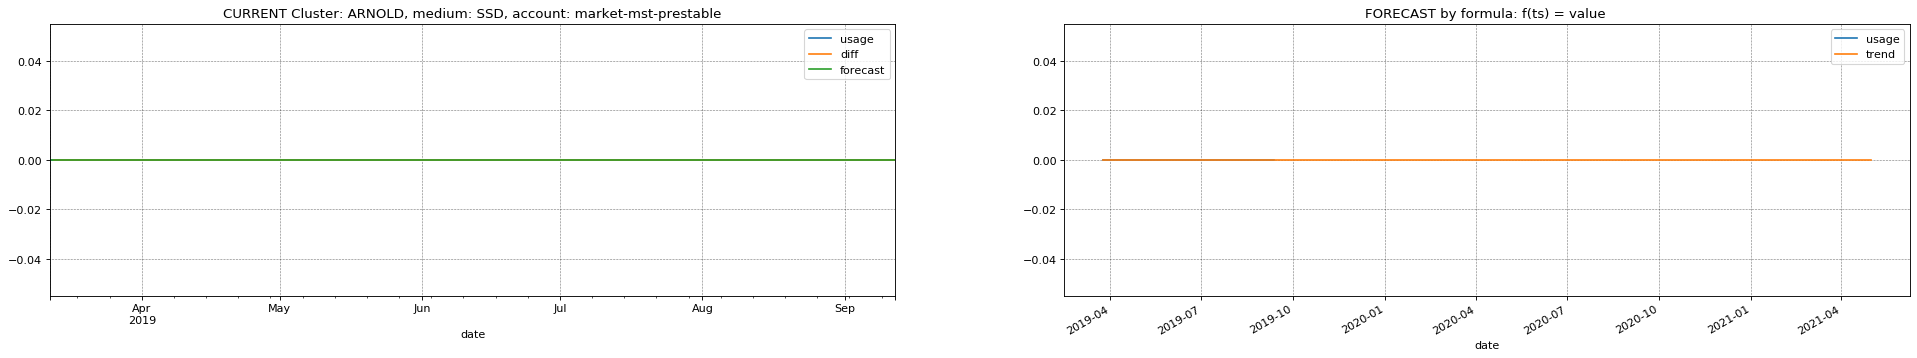

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


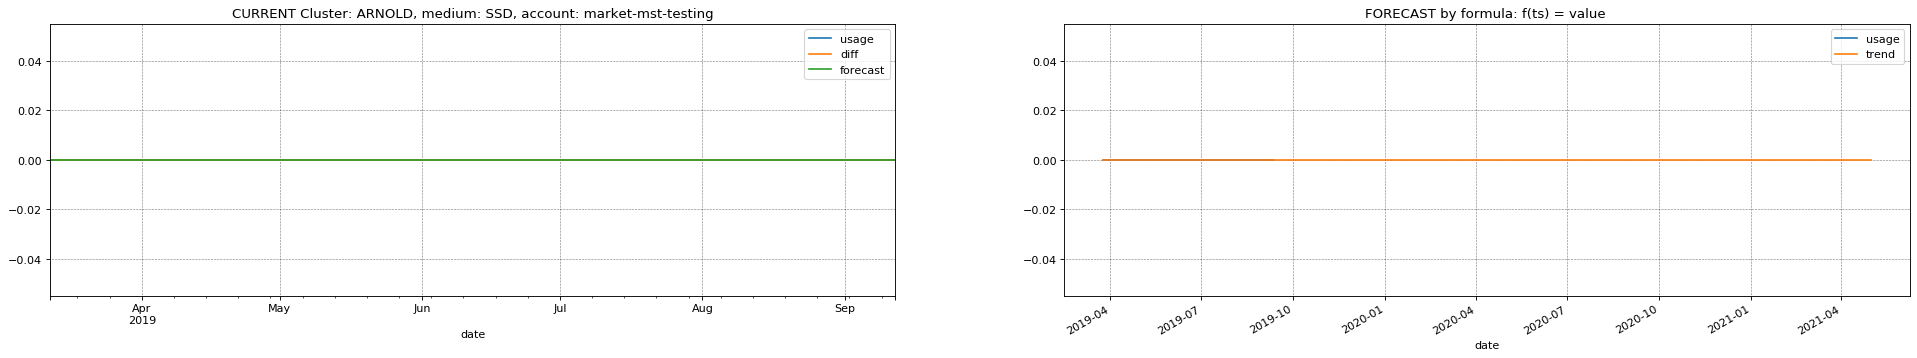

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


SENECA_SAS DEFAULT usage: 310 / 4946 Gb = 6.27 %


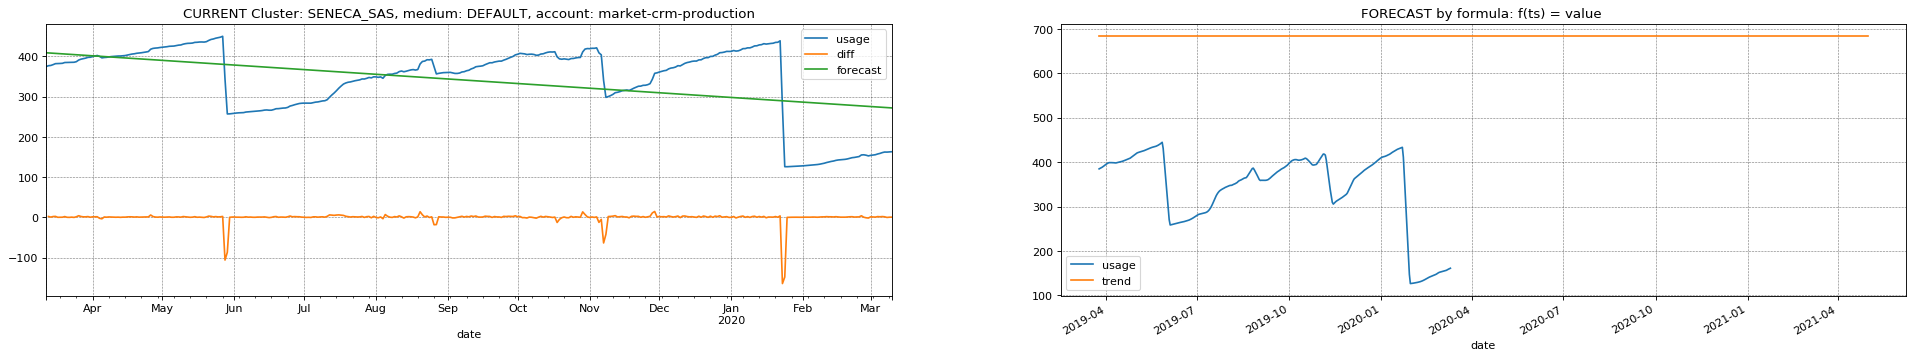

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.4667698767861124,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.09028638576410672}


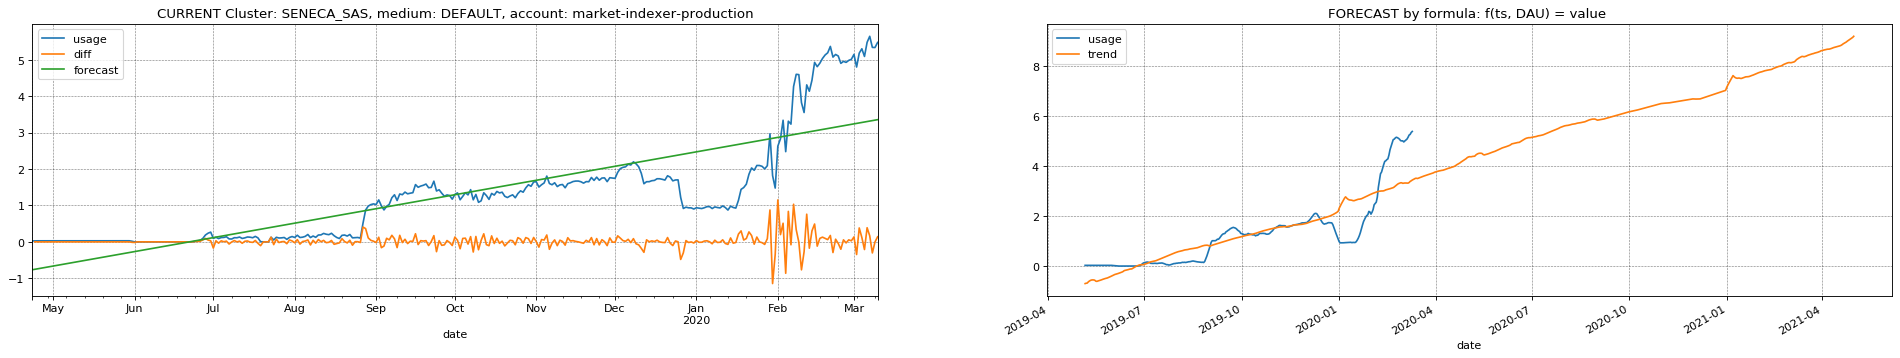

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.597360566109008}


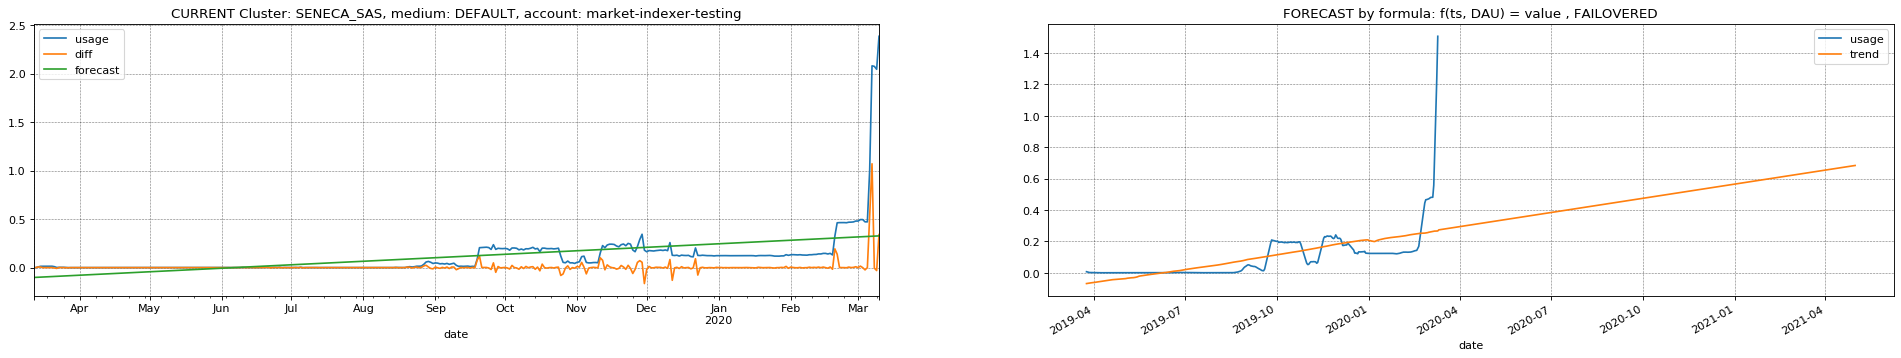

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.5131696636309346}


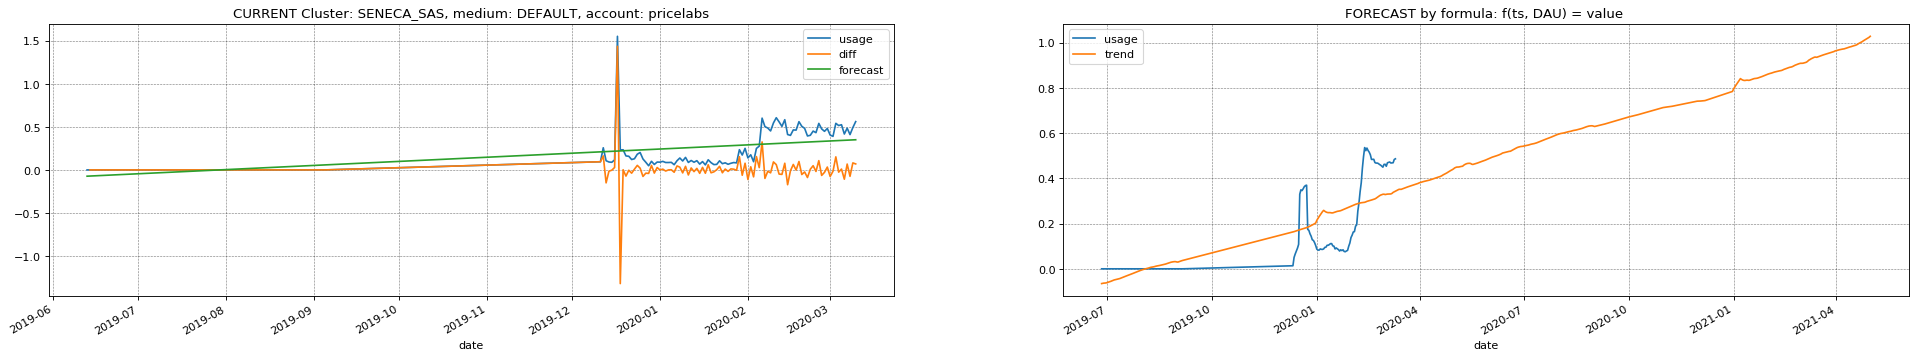

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.5702453005900863}


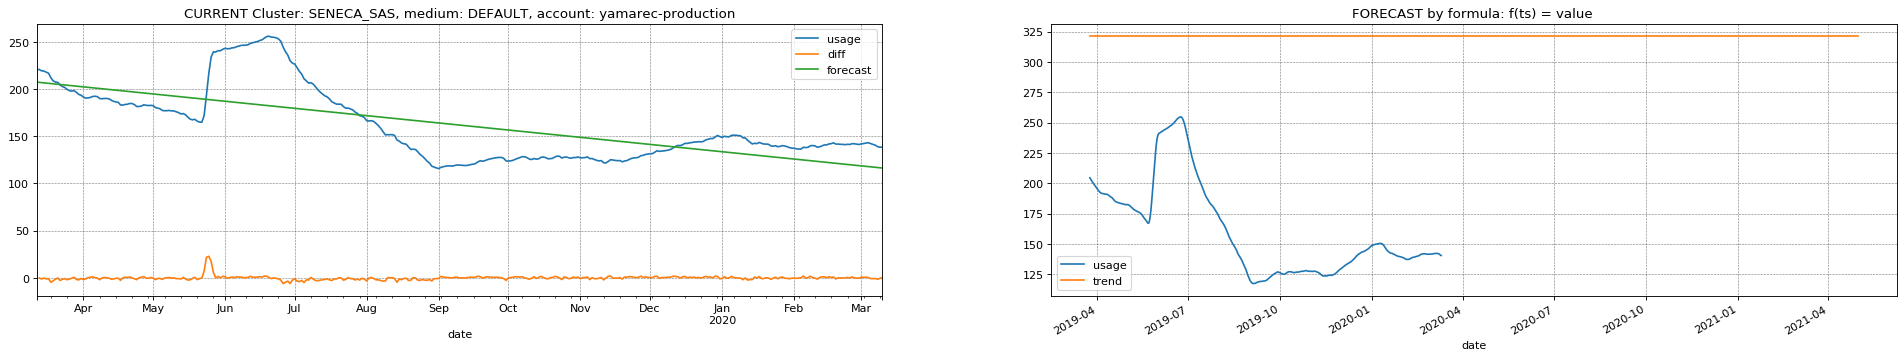

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.06960797186406438,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.6631379647650127}


SENECA_SAS SSD usage: 1358 / 7304 Gb = 18.59 %


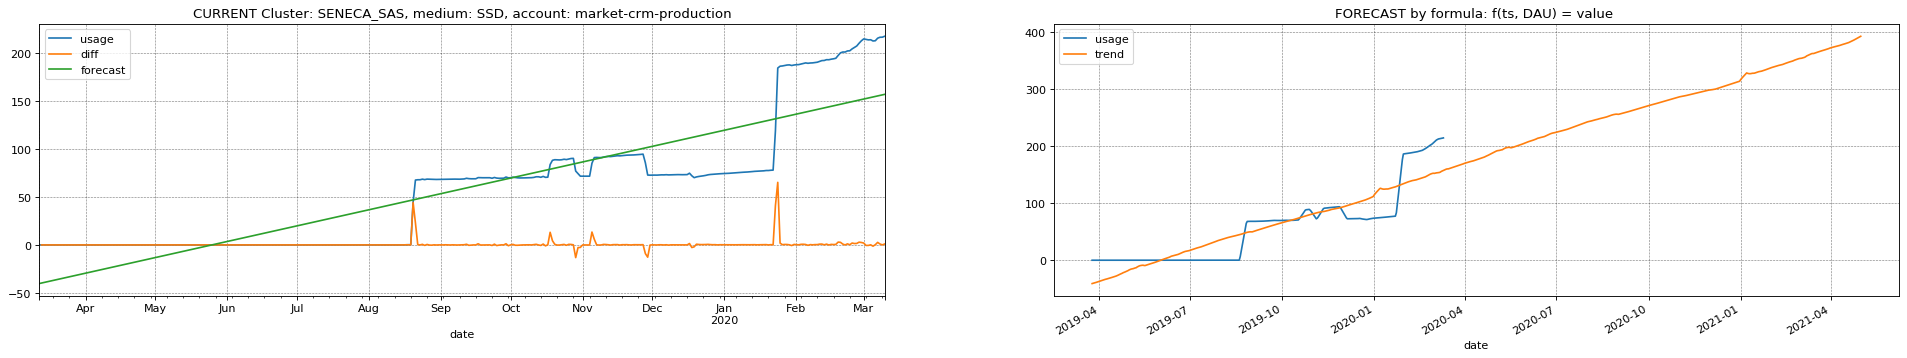

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.6570756167124091}


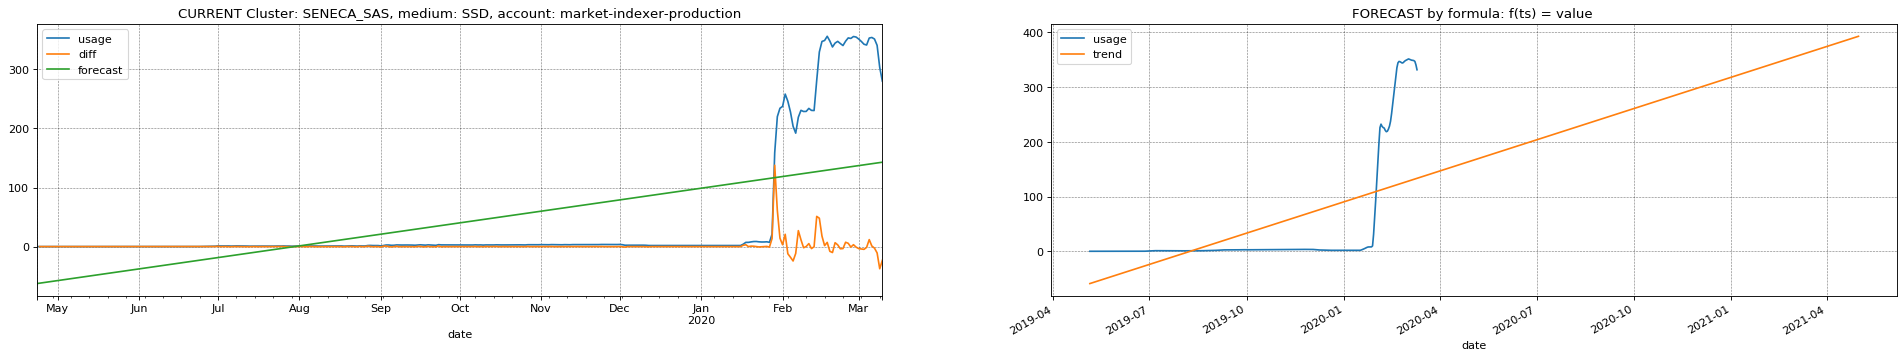

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.37371684690497214,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.1903106402820552}


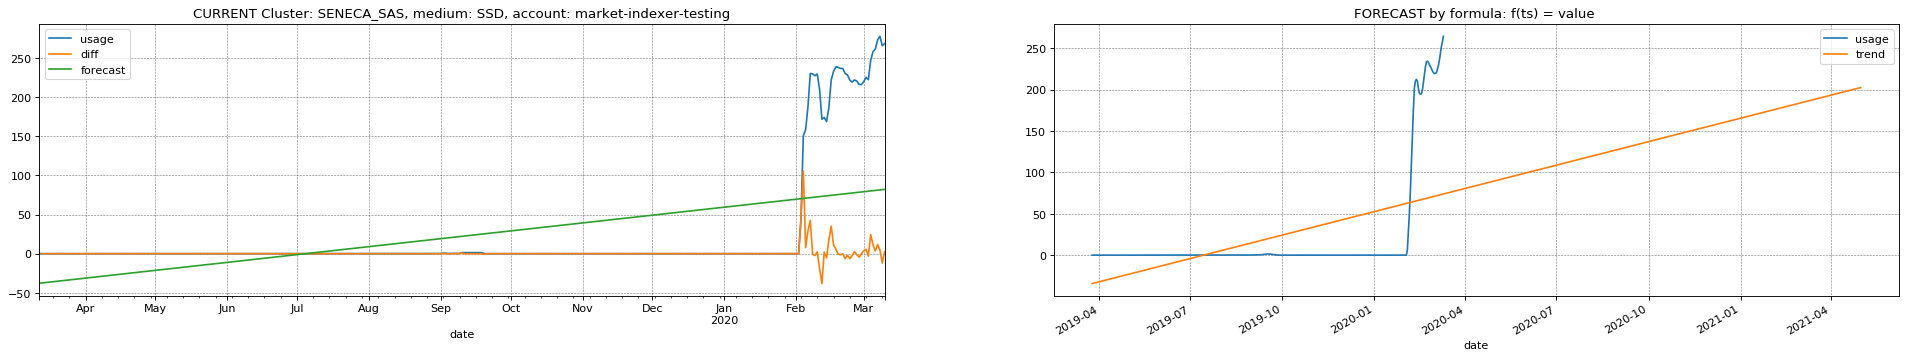

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.37607346772997347,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.1970470597724535}


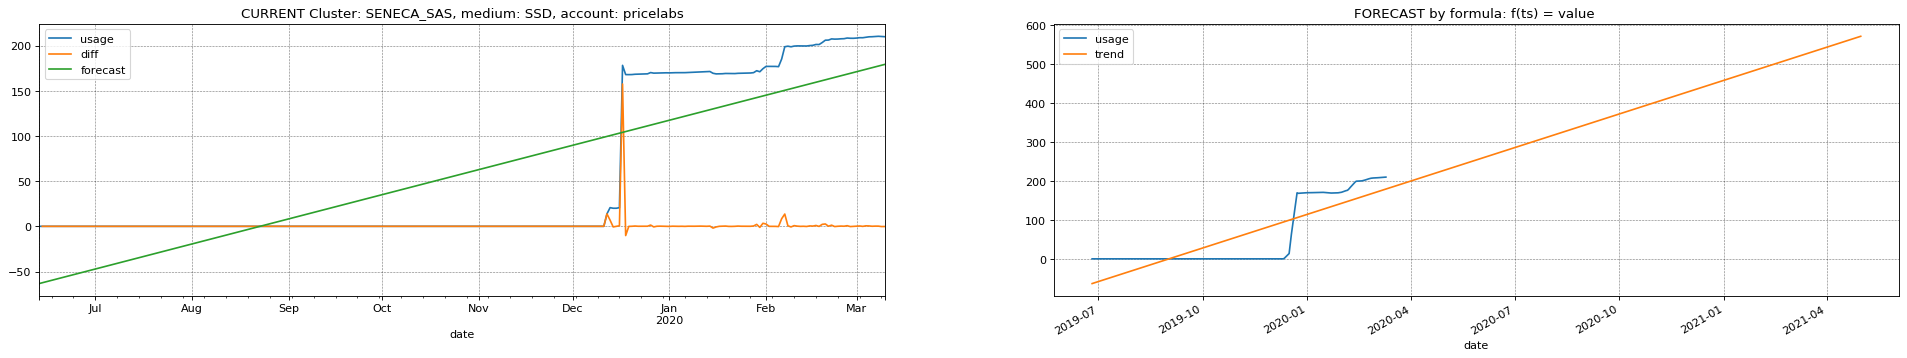

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.024291439282723933,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.29707834681265927}


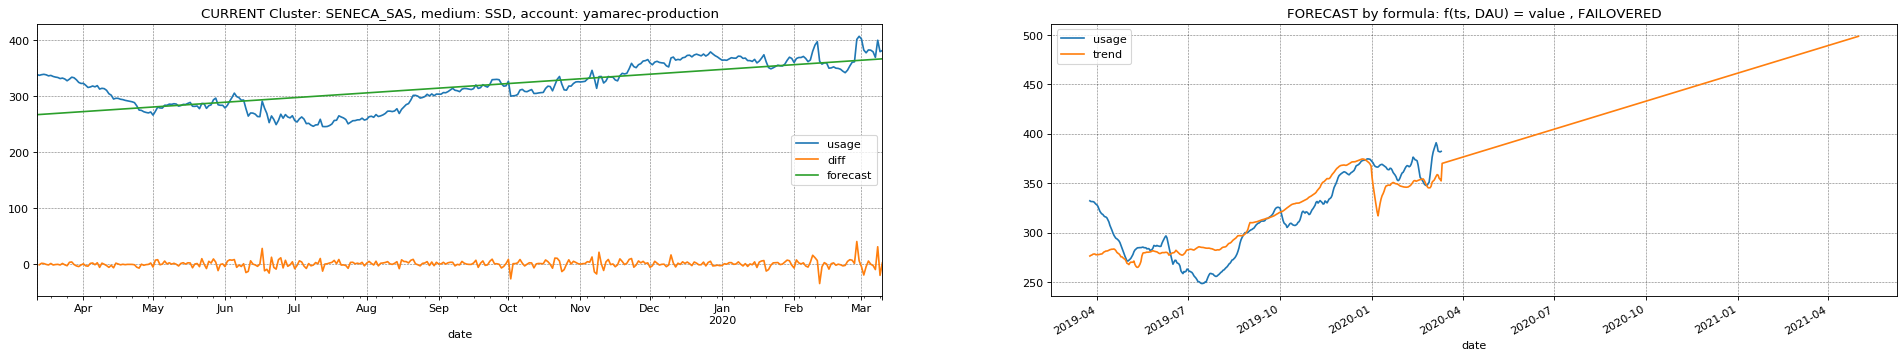

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.8354040878282392}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  values=['usage'], # в дифах кореляций не ищем
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid)

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb      reason  \
cluster    account                   medium                                    
HAHN       market-analyst            DEFAULT                4471  CUMULATIVE   
           market-mst-development    DEFAULT               13694  CUMULATIVE   
           market-mst-prestable      DEFAULT               43092         DAU   
           market-mst-testing        DEFAULT               36957  CUMULATIVE   
           market-analyst            SSD                       0  CUMULATIVE   
           market-mst-development    SSD                       0  CUMULATIVE   
           market-mst-prestable      SSD                       0  CUMULATIVE   
           market-mst-testing        SSD                       0  CUMULATIVE   
ARNOLD     market-analyst            DEFAULT                1639  CUMULATIVE   
           market-mst-development    DEFAULT                   0  CUMULATIVE   
           market-mst-prestable      DEFAULT                2311         DAU   
           market-mst-testing        DEFAULT                  12  CUMULATIVE   
           market-analyst            SSD                       0  CUMULATIVE   
           market-mst-development    SSD                       0  CUMULATIVE   
           market-mst-prestable      SSD                       0  CUMULATIVE   
           market-mst-testing        SSD                       0  CUMULATIVE   
SENECA_SAS market-crm-production     DEFAULT                 684  CUMULATIVE   
           market-indexer-production DEFAULT                  10         DAU   
           market-indexer-testing    DEFAULT                   1         DAU   
           pricelabs                 DEFAULT                   2         DAU   
           yamarec-production        DEFAULT                 322  CUMULATIVE   
           market-crm-production     SSD                     396         DAU   
           market-indexer-production SSD                     394  CUMULATIVE   
           market-indexer-testing    SSD                     203  CUMULATIVE   
           pricelabs                 SSD                     572  CUMULATIVE   
           yamarec-production        SSD                     499         DAU   

                                              usage_gb  quota_gb  
cluster    account                   medium                       
HAHN       market-analyst            DEFAULT      4276      5120  
           market-mst-development    DEFAULT     15022     15360  
           market-mst-prestable      DEFAULT     13136    307200  
           market-mst-testing        DEFAULT      7750     46080  
           market-analyst            SSD             0         0  
           market-mst-development    SSD             0         0  
           market-mst-prestable      SSD             0         0  
           market-mst-testing        SSD             0         0  
ARNOLD     market-analyst            DEFAULT      2722      5120  
           market-mst-development    DEFAULT         0     15360  
           market-mst-prestable      DEFAULT      1334    307200  
           market-mst-testing        DEFAULT        12     46080  
           market-analyst            SSD             0         0  
           market-mst-development    SSD             0         0  
           market-mst-prestable      SSD             0         0  
           market-mst-testing        SSD             0         0  
SENECA_SAS market-crm-production     DEFAULT       163       450  
           market-indexer-production DEFAULT         6       300  
           market-indexer-testing    DEFAULT         3      1024  
           pricelabs                 DEFAULT         1       100  
           yamarec-production        DEFAULT       139      3072  
           market-crm-production     SSD           218      1334  
           market-indexer-production SSD           280      1224  
           market-indexer-testing    SSD           269      1174  
           pricelabs                 SSD           210       50

In [14]:
for key, value in disk_forecast_df.query("predicted_usage_gb > 0").iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/disk-{cluster}-{account}-{medium}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()

### CPU

In [15]:
label = 'mst'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env in pool]

cluster_pools = {
#     Cluster.HAHN: _hahn_pools_list,
    Cluster.HAHN: ['market-production-mstat-tm-testing'],
#     Cluster.ARNOLD: _arnold_pools_list
    Cluster.ARNOLD: ['market-production-mstat-tm-testing'],
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-production-mstat-tm-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-production-mstat-tm-testing']}


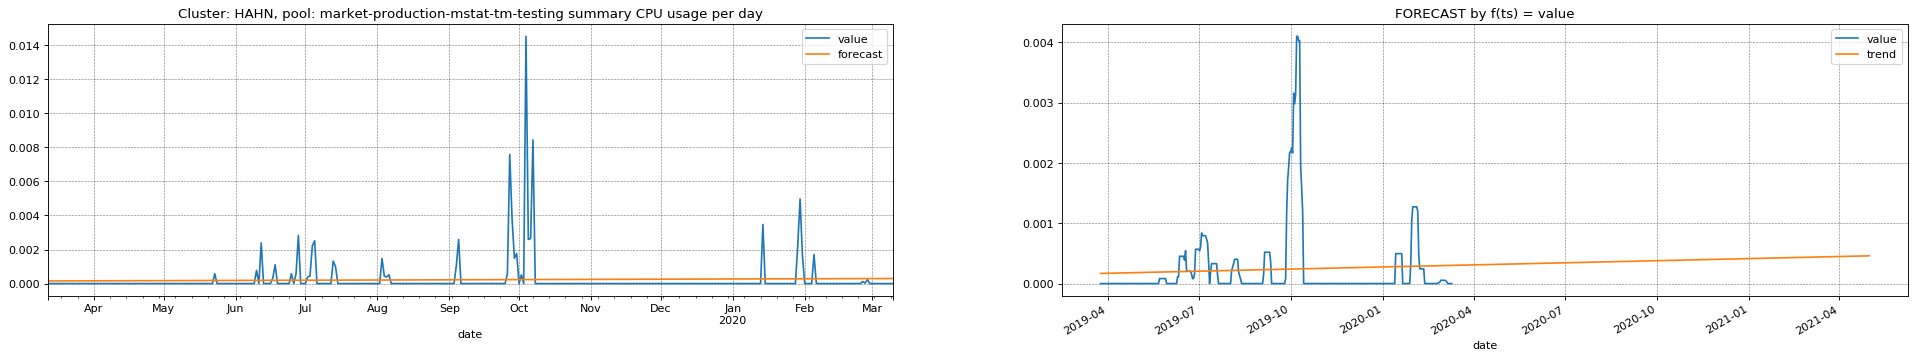

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.049348947462707286,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.009776035766454616,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.017501613699561394,
 <Formula.F_TS_DAU_eq_DIFF: 'f(ts, DAU) = diff'>: -0.01964995580055646}
Базовый прогноз: 0.000459848452903101 ядер


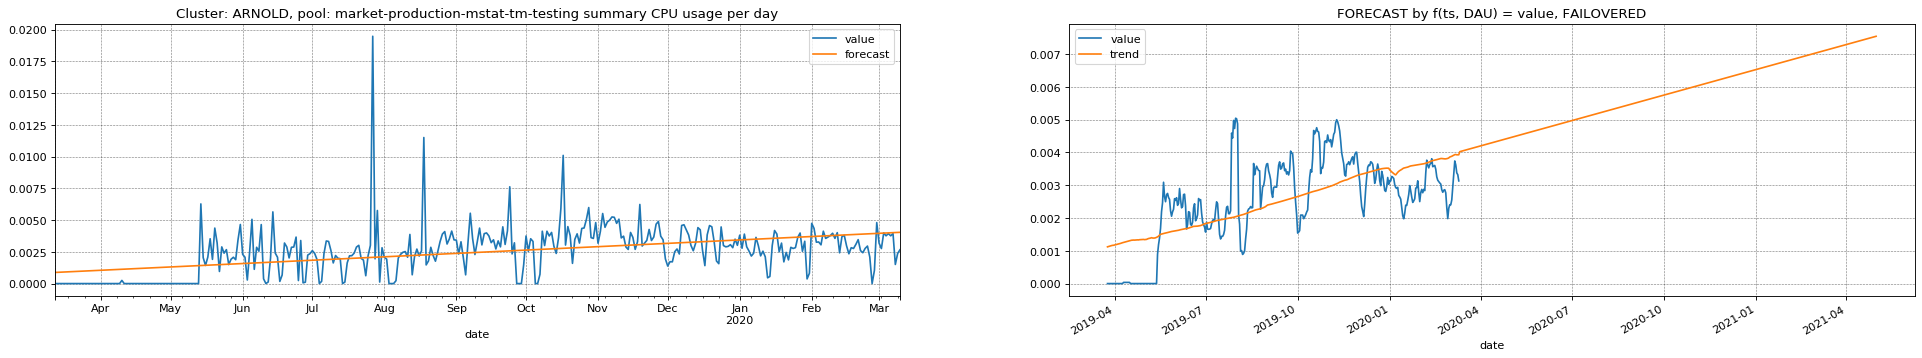

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.5357460422594783}
Базовый прогноз: 0.007546177081102501 ядер


In [16]:
cpu_forecast = get_cpu_forecast(predictor=predictor,
                                cluster_pools=cluster_pools,
                                formula=formula,
                                formula_strategy=formula_strategy,
                                features=features,
                                window=Window(),
                                decreasing_base_function=decreasing_base_function,
                                decreasing_reserve=decreasing_reserve,
                                consider_peaks=consider_peaks,
                                date_start=date_start,
                                date_end=date_end,
                                peaks_window_1=30,
                                peaks_window_2=90,
                                verbose=verbose,
                                grid=grid,
                                tail_depth=tail_depth,
                                quantile=quantile)

In [17]:
cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
cpu_forecast_df

,,predicted_usage,reason,peak_coef,usage,quota
cluster,pool,,,,,
HAHN,market-production-mstat-tm-testing,1,CUMULATIVE,1,0,0
ARNOLD,market-production-mstat-tm-testing,1,DAU,1,1,0


In [18]:
for key, value in cpu_forecast_df.query("predicted_usage > 0").iterrows():
    cluster, pool = key
    predicted_usage = value.predicted_usage
    quota = value.quota
    usage = value.usage
    peak_coef = value.peak_coef
    reason = value.reason
    
    cpu_quota=YtOrderRequestFileItemCpuQuota(
        pools=[pool],
        cpu_quota=quota,
        cpu_usage=usage,
        predicted_cpu_usage=predicted_usage,
        cpu_peak_coef=peak_coef
    )
    
    resource_info = whois.get_info(Cloud.YT, pool)
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       cpu_quota=cpu_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/pool-{cluster}-{pool}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()